In [5]:
from rfm_deployment.rfm_model import * 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import calendar
import datetime
import cairo
import gi
gi.require_version('Gtk', '3.0')
from gi.repository import Gtk
from itertools import product

%matplotlib inline

In [6]:
pd.set_option('display.max_columns', 500)

In [7]:
inicio = datetime.date(2020, 4, 25)
fin = datetime.date(2020, 2, 25)
months = -1

Ciclo--1:
La fecha de inicio es: 2020-04-25. La fecha final es: 2020-02-25.
Preprocesamiento...
-------------------------------------------------------------------------------------------------
La matriz de correlacion es:
            FRECUENCIA  RECENCIA     MONTO
FRECUENCIA    1.000000 -0.439324  0.628662
RECENCIA     -0.439324  1.000000 -0.353678
MONTO         0.628662 -0.353678  1.000000
-------------------------------------------------------------------------------------------------
Comenzando RFM--1..
-------------------------------------------------------------------------------------------------


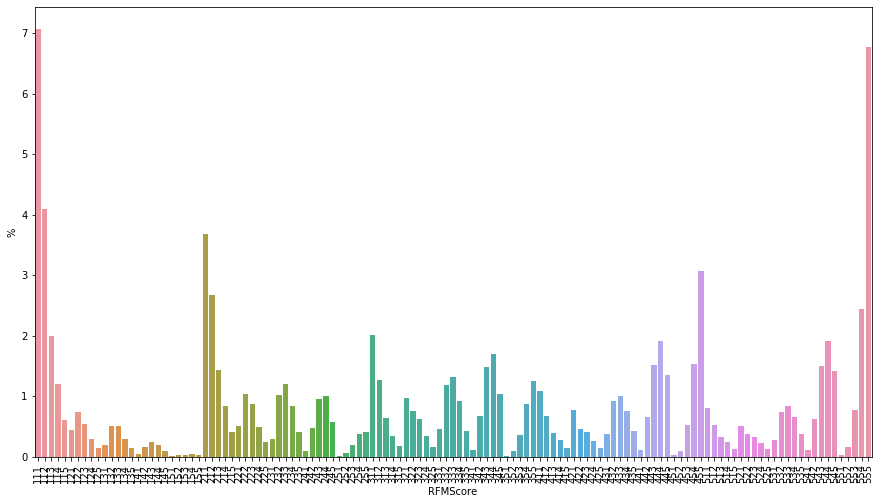

Procediendo a Segmentar...
-------------------------------------------------------------------------------------------------
La cantidad de comercios en el segmento Campeones es de: 332731
La cantidad de comercios en el segmento En Riesgo es de: 196050
La cantidad de comercios en el segmento Reciente operativo es de: 43083
La cantidad de comercios en el segmento Leales es de: 388154
La cantidad de comercios en el segmento Potencialmente Leales es de: 210699
La cantidad de comercios en el segmento Hibernando es de: 619110
La cantidad de comercios en el segmento Necesitan Atencion es de: 90353
La cantidad de comercios en el segmento Cercanos a Hibernar es de: 154892
La cantidad de comercios en el segmento No se pueden perder es de: 24473
La cantidad de comercios en el segmento Prometedores es de: 54085
-------------------------------------------------------------------------------------------------


In [8]:
fecha_final = add_months(inicio, -2)
contador = 1

trimestre = []
campeones = []
loyals = []
potential_loyal = []
news = []
promising = []
cant_lost = []
risk = []
need_atention = []
close_hibernating = []
hibernating = []

while fecha_final >= fin :
   
    fi_int = datetime_to_integer(inicio)
    ff_int = datetime_to_integer(fecha_final)
    print(f'Ciclo--{contador}:')
    print(f'La fecha de inicio es: {inicio}. La fecha final es: {fecha_final}.' )
    fecha_out = str(ff_int)
    fecha_in = str(fi_int)
    rfm = pd.read_csv(f'{fecha_in}--{fecha_out}.csv')
        #rfm = rfm.sample(frac=0.05)
    print('=================================================================================================')
    
    print('Preprocesamiento...')
    rfm = preprocesamiento(rfm)
    
    print('-------------------------------------------------------------------------------------------------')
    
    #EDA...
    #histogramas(rfm['RECENCIA'], rfm['FRECUENCIA'], rfm['MONTO'])
    #print('-------------------------------------------------------------------------------------------------')
    
    rfm_corr = rfm.drop(['DIM_CUENTAS', 'APERTURA', 'ANTIGUEDAD', 'RENTABILIDAD', 'NIVEL_RIESGO_TRIM', 'LIMITE_CREDITO', 'DNI'], axis = 1)
    print('La matriz de correlacion es:')
    print(rfm_corr.corr())
    print('-------------------------------------------------------------------------------------------------')
   
    #Modelo RFM...
    print(f'Comenzando RFM--{contador}..')
    rfm = rfm_scoring(rfm, fecha_in, fecha_out)
    print('-------------------------------------------------------------------------------------------------')
   
    #print('Algunas graficas...')
    #histogramas2(rfm)
        
    #print('-------------------------------------------------------------------------------------------------')
    #Procediendo a Segmentar...
    #print('Distribución de clientes según el Score RFM')
    segmentar(rfm, fecha_in, fecha_out)
    #print('-------------------------------------------------------------------------------------------------')
   
    #Segmentos...
    print('Procediendo a Segmentar...')
    print('-------------------------------------------------------------------------------------------------')
    rfm_segmentado, dic_dni = label_segmentos(rfm, fecha_in, fecha_out)
    #Guardamos los dnis para cada segmento en un archivo json.
    #with open (f'dic_dni--{fecha_in}--{fecha_out}', 'w') as output:
    #   json.dump(dic_dni, output)
   
    #Creando listas para generar gráfico de lineas como función de los trimestres')
   
    entrada = datetime.datetime.strptime(f'{inicio}', '%Y-%m-%d').strftime('%d/%m/%Y')
    salida = datetime.datetime.strptime(f'{fecha_final}', '%Y-%m-%d').strftime('%d/%m/%Y')
    
    trimestre.append(f'{entrada}--{salida}')
    campeones.append(rfm_segmentado.loc['Campeones', '%'])
    loyals.append(rfm_segmentado.loc['Leales', '%'])
    potential_loyal.append(rfm_segmentado.loc['Potencialmente Leales', '%'])
    news.append(rfm_segmentado.loc['Reciente operativo', '%'])
    promising.append(rfm_segmentado.loc['Prometedores', '%'])
    cant_lost.append(rfm_segmentado.loc['No se pueden perder', '%'])
    risk.append(rfm_segmentado.loc['En Riesgo', '%'])
    need_atention.append(rfm_segmentado.loc['Necesitan Atencion', '%'])
    close_hibernating.append(rfm_segmentado.loc['Cercanos a Hibernar', '%'])
    hibernating.append(rfm_segmentado.loc['Hibernando', '%'])
   
   
    inicio = add_months(inicio, months)
    fecha_final = add_months(fecha_final, months)
    contador += 1
   
print('=================================================================================================')
print('=================================================================================================')
#print('Evolución trimestral de la población en cada segmento...')   

#dic = {'Trimestre': trimestre ,'Campeones': campeones , 'Leales': loyals, 'Potencialmente Leales': potential_loyal,
#       'Reciente operativo': news, 'Prometedores': promising, 'No se pueden perder': cant_lost,'En Riesgo': risk ,
#       'Necesitan Atencion': need_atention , 'Cercanos a Hibernar': close_hibernating , 'Hibernando': hibernating} 

#df_lineas = pd.DataFrame(dic)
#df_lineas.to_csv('1anio_porcentajes.csv', index = False)
# reverse the dataframe
#df_lineas = df_lineas[::-1]
#evolucion_trimestral_segmentos(df_lineas)

#Generamos .png de diagrama RFM con una descripción
rfm_describe()

print('-------------------------------------------------------------------------------------------------')

## Generando diagrama RFM para un trimestre determinado...

In [9]:
fecha_in =20200425  # Fecha límite superior para el trimestre de interés
fecha_out =20200225 # Fecha límite inferior para el trimestre de interés

rfm_grafico = pd.read_csv(f'line_plot-{fecha_in}--{fecha_out}.csv') 
df = pd.read_csv(f'rfm-segmentos-{fecha_in}--{fecha_out}.csv')
rfm_prom = df[['RECENCIA', 'FRECUENCIA', 'MONTO', 'Segment']].groupby(['Segment']).median().round(2)
rfm_prom = rfm_prom.rename(columns = {'RECENCIA': 'R_MEDIAN', 'FRECUENCIA': 'F_MEDIAN', 'MONTO': 'M_MEDIAN'})
rfm_prom = rfm_prom.reset_index() 
rfm_x_grafico = pd.merge(rfm_prom, rfm_grafico, on='Segment', how='inner')
rfm_x_grafico['%'] = rfm_x_grafico['%'].apply(lambda x : str(int(x))+'%')
rfm_x_grafico['cantidad'] = rfm_x_grafico['cantidad'].apply(lambda x : str(x))
rfm_x_grafico['R_MEDIAN'] = rfm_x_grafico['R_MEDIAN'].apply(lambda x : str(x))
rfm_x_grafico['F_MEDIAN'] = rfm_x_grafico['F_MEDIAN'].apply(lambda x : str(x))
rfm_x_grafico['M_MEDIAN'] = rfm_x_grafico['M_MEDIAN'].apply(lambda x : str(x))
rfm_percentaje_dic = dict(zip(rfm_x_grafico.Segment, rfm_x_grafico['%']))
rfm_cantidad_dic = dict(zip(rfm_x_grafico.Segment, rfm_x_grafico.cantidad))
rfm_R_MEDIAN_dic = dict(zip(rfm_x_grafico.Segment, rfm_x_grafico.R_MEDIAN))
rfm_F_MEDIAN_dic = dict(zip(rfm_x_grafico.Segment, rfm_x_grafico.F_MEDIAN))
rfm_M_MEDIAN_dic = dict(zip(rfm_x_grafico.Segment, rfm_x_grafico.M_MEDIAN))

app = RFM_graph()
app.porcentajes = rfm_percentaje_dic
app.cantidad = rfm_cantidad_dic
app.R_MEDIAN = rfm_R_MEDIAN_dic
app.F_MEDIAN = rfm_F_MEDIAN_dic
app.M_MEDIAN = rfm_M_MEDIAN_dic
Gtk.main()

# Analisis de Migracion

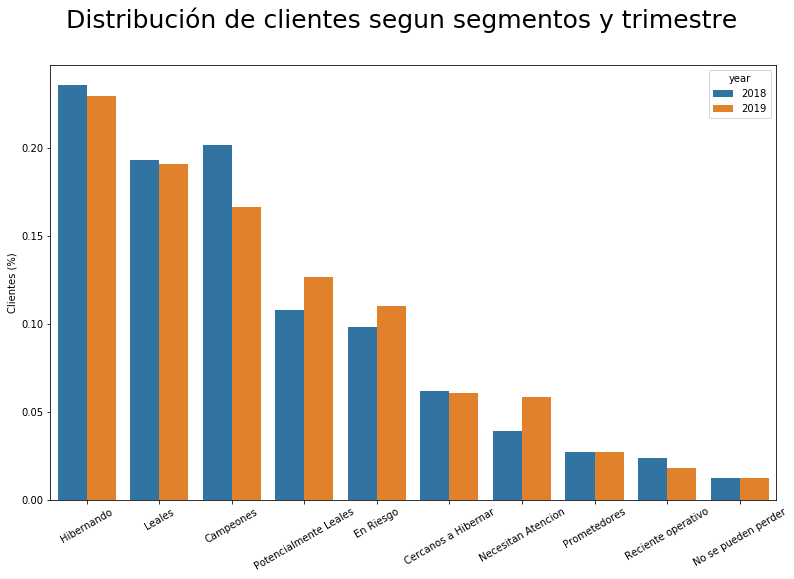

--------------------------------------------------------------------------------------------------------
Porcentaje de migración de clientes entre segmentos comparando el mismo trimestre en años consecutivos..


Segment_2019,Campeones,Cercanos a Hibernar,En Riesgo,Hibernando,Leales,Necesitan Atencion,No se pueden perder,Potencialmente Leales,Prometedores,Reciente operativo,Total
Segment_2018,,,,,,,,,,,
Campeones,37.961688,1.811227,8.489432,6.687296,30.332917,3.456113,2.141888,7.842926,0.726983,0.549530,100.0
Cercanos a Hibernar,4.940518,10.992403,9.821497,35.915501,8.414646,7.759733,0.350610,14.612068,4.421217,2.771806,100.0
En Riesgo,11.192516,5.625688,15.898594,22.914777,17.985029,7.188610,1.186907,14.051063,2.369658,1.587159,100.0
Hibernando,4.383555,9.892688,10.243188,40.345542,7.252409,5.814956,0.349059,13.692846,4.810439,3.215318,100.0
Leales,23.859792,3.009524,11.850855,10.204698,31.486003,5.546559,2.105999,10.140763,1.076360,0.719447,100.0
Necesitan Atencion,8.994369,7.935901,13.316880,23.858106,15.797066,9.781702,0.603101,15.421649,2.558398,1.732828,100.0
No se pueden perder,25.120482,2.174151,13.888280,9.123768,32.174151,3.532311,4.989047,7.250821,0.974808,0.772180,100.0
Potencialmente Leales,9.273504,6.851640,11.994472,25.138667,13.968941,7.331217,0.560348,19.622270,3.220738,2.038202,100.0
Prometedores,4.846831,10.365869,8.996651,37.866799,7.458762,5.784447,0.362148,15.609575,5.355327,3.353590,100.0


In [6]:
fecha_in_1 =20191025  # 1 etiqueta al trimestre más actual
fecha_out_1 =20190825
fecha_in_2 =20181025
fecha_out_2 =20180825

migraciones(fecha_in_1, fecha_in_2, fecha_out_1, fecha_out_2)

# Analisis de Riesgo

Segment,Campeones,Cercanos a Hibernar,En Riesgo,Hibernando,Leales,Necesitan Atencion,No se pueden perder,Potencialmente Leales,Prometedores,Reciente operativo
NIVEL_RIESGO_TRIM,,,,,,,,,,
RB,62.415717,51.255591,41.889856,47.667177,53.761239,49.560320,34.874515,54.825223,54.650351,52.194609
RMB,13.042008,11.733383,12.312361,11.038446,13.951966,12.800942,13.462909,12.315012,11.132099,11.104929
RM,12.197629,13.210626,14.991485,13.123391,14.591179,14.936765,16.847439,13.496715,12.339342,12.471151
RMA,4.497390,5.739844,6.847836,5.731343,5.712011,6.257616,7.616182,5.572204,5.183482,5.551434
RA,7.847257,18.060556,23.958462,22.439643,11.983605,16.444357,27.198955,13.790845,16.694726,18.677877


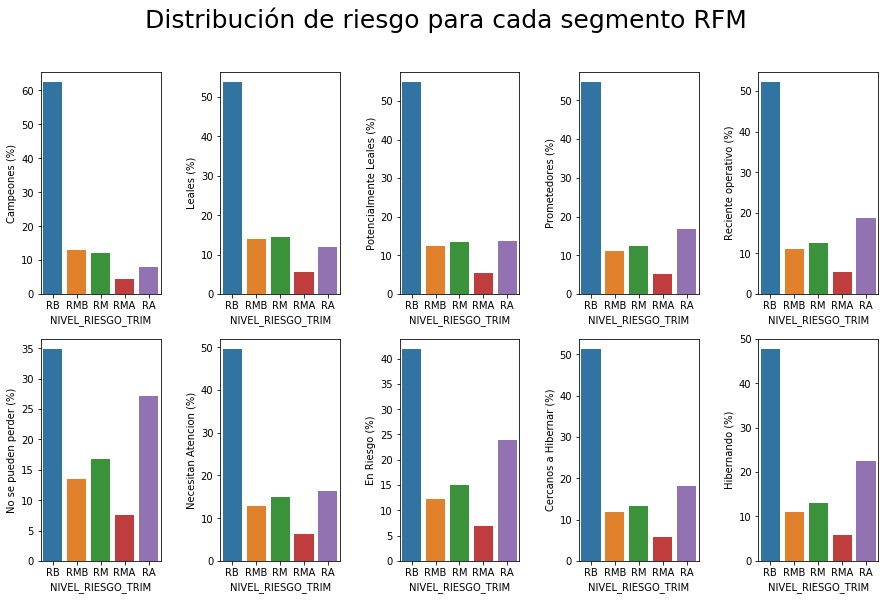

In [7]:
fecha_in_1 =20191025  # 1 etiqueta al trimestre mas actual
fecha_out_1 =20190825
riesgo(fecha_in_1, fecha_out_1)

# Analisis de rentabilidad

/home/mmontero/Escritorio/Proyectos/NARANJA/Modelo_RFM/RFM_deployment/src/rfm_deployment/rfm_model.py:175: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_quintil = rfm[rfm['RENTABILIDAD'] > q0][rfm['RENTABILIDAD'] < q6]


Segment,Campeones,Cercanos a Hibernar,En Riesgo,Hibernando,Leales,Necesitan Atencion,No se pueden perder,Potencialmente Leales,Prometedores,Reciente operativo
RENT_QUINTIL,,,,,,,,,,
Q1,7.501967,28.538901,15.793560,30.280484,8.732541,17.632586,8.036880,19.848761,31.089205,30.139465
Q2,13.193799,23.269182,19.248868,23.288795,14.833051,21.158609,11.202564,21.910476,23.744787,22.956819
Q3,17.980725,19.703541,21.035184,19.240316,19.397256,21.603785,16.338886,21.107733,18.787575,19.020899
Q4,23.407880,16.154305,21.638445,15.687958,23.616848,20.824522,23.303391,19.892352,15.104533,15.631861
Q5,37.915629,12.334070,22.283942,11.502446,33.420304,18.780498,41.118278,17.240679,11.273899,12.250956


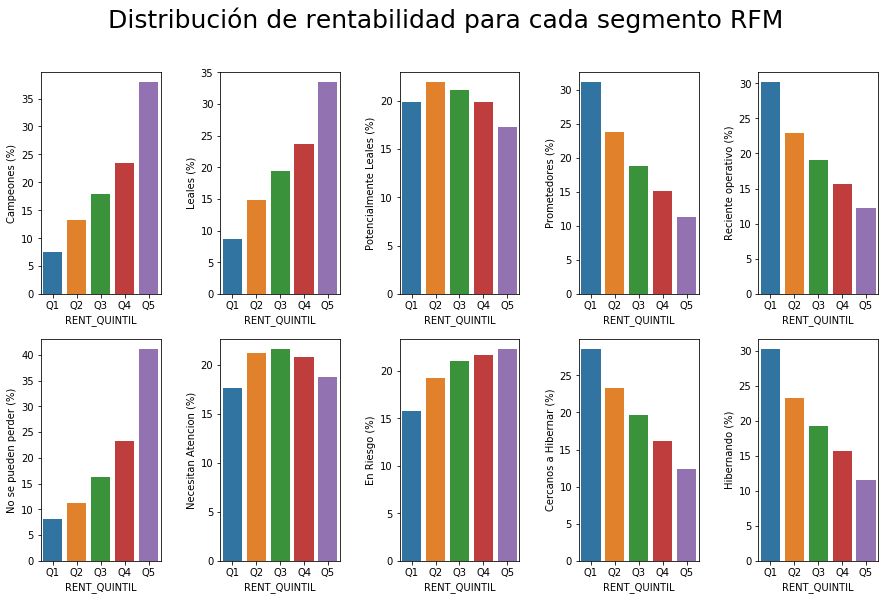

In [8]:
fecha_in_1 = 20191025
fecha_out_1 = 20190825
rentabilidad(fecha_in_1, fecha_out_1)

/home/mmontero/Escritorio/Proyectos/NARANJA/Modelo_RFM/RFM_deployment/src/rfm_deployment/rfm_model.py:222: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_percentil = rfm[rfm['RENTABILIDAD'] > q0][rfm['RENTABILIDAD'] < q6]


-------------------------------------------------------------------------------------------------
El 10% de los clientes más rentables explican el 25.28% de la rentabilidad total
-------------------------------------------------------------------------------------------------


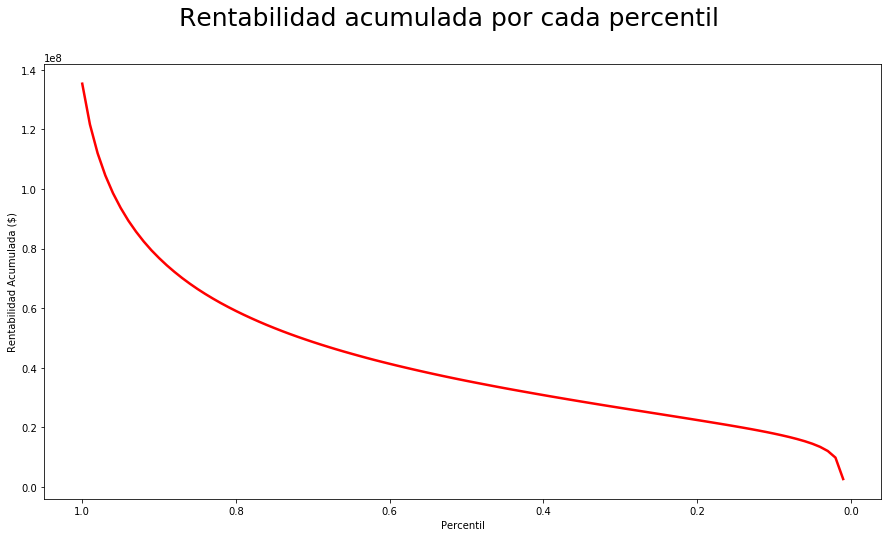

In [9]:
fecha_in_1 = 20191025
fecha_out_1 = 20190825
porcentaje_mejores_clientes = 10 #este variable es necesaria para verificar si se cumple la regla de Pareto
df = rentabilidad_acum(fecha_in_1, fecha_out_1, porcentaje_mejores_clientes)

In [10]:
#Esta función demora muchisimo tiempo
#fecha_in_1 = 20191025
#fecha_out_1 = 20190825
#df = rent_div_percentiles(fecha_in_1, fecha_out_1)

# Analisis de caracteristicas de las personas en cada segmento y para cada quintil

In [11]:
rfm = pd.read_csv('rfm-segmentos-20191025--20190825.csv')

In [12]:
rfm

,DIM_CUENTAS,DNI,APERTURA,ANTIGUEDAD,LIMITE_CREDITO,RENTABILIDAD,NIVEL_RIESGO_TRIM,FRECUENCIA,RECENCIA,MONTO,R_Quintil,F_Quintil,M_Quintil,RFMScore,Total_score,Segment
0,914472,12784888,2006-10-06,155.84,132600.00,1058.359600,05 - RB,2,67,9149.17,1,1,3,113,5,Hibernando
1,564472,8004367,2005-06-13,171.61,135000.00,2559.501700,05 - RB,11,6,51389.82,4,4,5,445,13,Leales
2,2190914,25639155,2004-09-24,180.26,46000.00,5249.944075,01 - RA,6,24,4301.66,2,3,2,232,7,En Riesgo
3,1880002,23231071,2004-06-24,183.26,100000.00,5996.037625,05 - RB,4,24,36794.21,2,3,5,235,10,En Riesgo
4,1147886590,10713011,2015-08-28,49.13,21709.57,1172.280150,05 - RB,1,15,1335.10,3,1,1,311,5,Cercanos a Hibernar
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2201510,1724055,21907719,2004-04-22,185.32,42100.00,975.857425,05 - RB,2,60,2920.00,1,1,1,111,3,Hibernando
2201511,1250753417,30145072,2017-11-25,22.23,40000.00,1801.971375,03 - RM,3,14,23491.97,3,2,5,325,10,Cercanos a Hibernar
2201512,1573134,20387155,2011-12-06,93.84,52200.00,3038.344450,01 - RA,2,16,15390.50,3,1,4,314,8,Cercanos a Hibernar
2201513,922926,12852748,2004-05-12,184.65,68200.00,4209.634575,05 - RB,9,17,36169.55,3,4,5,345,12,Leales


In [13]:
q6 = float(rfm[['RENTABILIDAD']].mean() + 3 * rfm[['RENTABILIDAD']].std())
q0 = float(rfm[['RENTABILIDAD']].mean() - 3 * rfm[['RENTABILIDAD']].std())
df_quintil = rfm[rfm['RENTABILIDAD'] > q0][rfm['RENTABILIDAD'] < q6]

/home/mmontero/anaconda3/envs/RFM_clon/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


In [14]:
df_quintil.head()

,DIM_CUENTAS,DNI,APERTURA,ANTIGUEDAD,LIMITE_CREDITO,RENTABILIDAD,NIVEL_RIESGO_TRIM,FRECUENCIA,RECENCIA,MONTO,R_Quintil,F_Quintil,M_Quintil,RFMScore,Total_score,Segment
0,914472,12784888,2006-10-06,155.84,132600.00,1058.359600,05 - RB,2,67,9149.17,1,1,3,113,5,Hibernando
1,564472,8004367,2005-06-13,171.61,135000.00,2559.501700,05 - RB,11,6,51389.82,4,4,5,445,13,Leales
2,2190914,25639155,2004-09-24,180.26,46000.00,5249.944075,01 - RA,6,24,4301.66,2,3,2,232,7,En Riesgo
3,1880002,23231071,2004-06-24,183.26,100000.00,5996.037625,05 - RB,4,24,36794.21,2,3,5,235,10,En Riesgo
4,1147886590,10713011,2015-08-28,49.13,21709.57,1172.280150,05 - RB,1,15,1335.10,3,1,1,311,5,Cercanos a Hibernar


In [15]:
quintiles = df_quintil[['RENTABILIDAD']].quantile(q=[0.2,0.4,0.6,0.8])

In [16]:
quintiles

,RENTABILIDAD
0.2,1049.117310
0.4,1437.051725
0.6,1928.074935
0.8,2764.006290


In [17]:
q1 = df_quintil[df_quintil['RENTABILIDAD'] <= 1048.842920]

In [18]:
#analizamos caracteristicas de los campeones dentro del primer quintil

In [19]:
q1_champ = q1[q1['Segment'] == 'Campeones']

In [20]:
q1_champ.head(10)

,DIM_CUENTAS,DNI,APERTURA,ANTIGUEDAD,LIMITE_CREDITO,RENTABILIDAD,NIVEL_RIESGO_TRIM,FRECUENCIA,RECENCIA,MONTO,R_Quintil,F_Quintil,M_Quintil,RFMScore,Total_score,Segment
11,553538822,16033669,2013-01-18,80.45,51800.0,996.23480,05 - RB,28,2,15603.28,5,5,4,554,14,Campeones
163,1251661762,95810084,2018-08-02,13.97,20660.0,866.85815,02 - RMA,25,1,11382.13,5,5,4,554,14,Campeones
247,1813499,22713379,2000-05-23,232.29,176400.0,728.49020,05 - RB,10,4,13237.58,5,4,4,544,13,Campeones
306,437398211,17626274,2012-07-25,86.23,23000.0,862.01875,05 - RB,19,1,11200.59,5,5,3,553,13,Campeones
374,1251358927,6924640,2002-08-05,205.87,66700.0,481.81850,05 - RB,9,1,7581.23,5,4,3,543,12,Campeones
392,924828231,11046337,2019-01-18,8.45,37130.0,396.62200,01 - RA,7,4,6396.62,5,4,3,543,12,Campeones
453,69064069,94234492,2010-09-22,108.32,175500.0,1030.48855,05 - RB,12,1,23694.87,5,5,5,555,15,Campeones
466,581052581,28532118,2013-03-06,78.84,23000.0,733.49080,05 - RB,8,1,15633.60,5,4,4,544,13,Campeones
580,1251899128,6501513,2019-01-29,8.10,41470.0,623.88350,03 - RM,12,3,13068.63,5,5,4,554,14,Campeones
619,66683663,12226376,2010-09-08,108.77,62400.0,855.73420,04 - RMB,23,5,10217.07,5,5,3,553,13,Campeones
